In [4]:
import datetime
import io
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import snp
import yfinance as yf
from dotenv import load_dotenv
from IPython.display import clear_output

In [40]:
DATASET_DIR = "dataset/"
DATASET_CSV = DATASET_DIR + "%s.csv"

TICKER_LIMIT = 500
PERIOD = "max"
INTERVAL = "1d"

load_dotenv()


def get_csv_name(ticker):
    return DATASET_CSV % (ticker)

def get_tickers():
    csvs = os.listdir(DATASET_DIR)
    return sorted(list(map(lambda x: x.replace(".csv", ""), csvs)))

In [ ]:
# download data - yfinance
tickers = snp.snp500_tickers()[:TICKER_LIMIT]
for i, t in enumerate(tickers):
    try:
        df = yf.download(
            t, period=PERIOD, interval=INTERVAL, progress=False, rounding=True
        )

        df.to_csv(get_csv_name(t))
        df = pd.read_csv(get_csv_name(t))

        # rename columns, delete unnecessary rows, cut Date time
        df.rename(
            columns={
                "Price": "Date",
                # "Open": "open",
                # "High": "high",
                # "Low": "low",
                # "Close": "close",
                # "Volume": "volume",
                # "Adj Close": "adj_close",
            },
            inplace=True,
        )
        df.drop(index=[0, 1], inplace=True)
        df["Date"] = df["Date"].str.replace(" 00:00:00+00:00", "")
        # Convert 'Date' to datetime

        print(
            f"Ticker: {t} {i + 1}/{len(tickers)} ({round((i + 1) / len(tickers) * 100, 2)}%)"
        )
        print(df.head())
        clear_output(wait=True)

        df.to_csv(get_csv_name(t), index=False)

    except KeyboardInterrupt as e:
        print(e)
        break

In [42]:
# add SMA200 to data
tickers = get_tickers()
t = tickers[0]
df = pd.read_csv(get_csv_name(t))

SMA_PERIOD = 200
# Compute SMA
df["sma"] = df["Adj Close"].rolling(window=SMA_PERIOD).mean().round(2)

# Select and rename the required columns
df = (
    df[["Adj Close", "Volume", "sma"]]
    .iloc[199:]
    .rename(columns={"Adj Close": "price", "Volume": "volume"})
)

# Save to a CSV file
df.to_csv(f"{t}.csv", index=False)

print(f"Ticker: {t}")
print(df.head())
print(df.dtypes)

Ticker: A
     price   volume    sma
199  37.35  3138230  44.90
200  37.31  2044994  44.95
201  36.22  2235402  45.01
202  37.35  2123003  45.06
203  35.77  2015776  45.12
price     float64
volume      int64
sma       float64
dtype: object


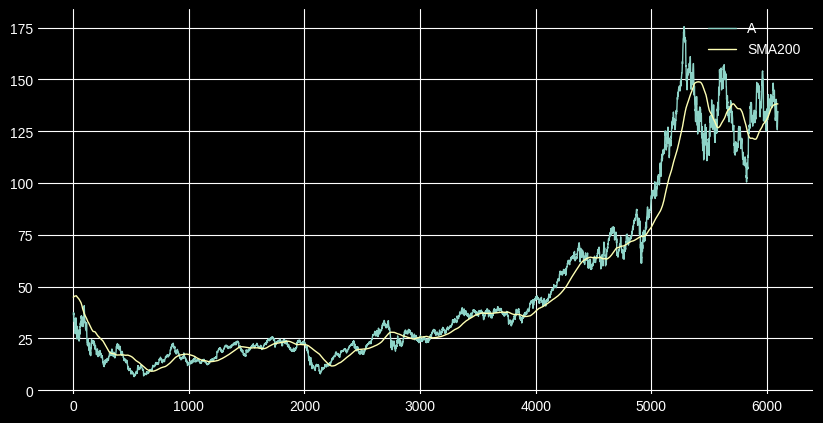

In [43]:
plt.style.use("default")
plt.style.use("seaborn-v0_8-darkgrid")
plt.style.use("dark_background")

# Plot the 'Close' price against the 'Date'
plt.figure(figsize=(10, 5))

df = pd.read_csv(f"{t}.csv")
plt.plot(df.index, df["price"], label="price", linewidth=1)
plt.plot(df.index, df["sma"], label="sma", linewidth=1)

plt.grid(True)
plt.legend([t, "SMA200"])

plt.show()